# COVID ENHANCED SEARCH ENGINE USING NLP AND RNN

### Loading all required libraries 

In [6]:
# importing all required libraries 
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import missingno
import seaborn as sns

from collections import Counter

import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

import re
import string
import nltk
import spacy
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
#nltk.download('vader_lexicon')
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from wordcloud import STOPWORDS

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
import itertools

# NLP
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

# word2vec model
import gensim

# keras model libraries
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D, Activation, Input
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


In [ ]:
pip install fake-useragent

### Loading natural language queries to web scrape google website

In [0]:
queries = open('/content/drive/My Drive/google_queries.txt', encoding='utf-8').read().split('\n')

In [0]:
import urllib
import requests
from fake_useragent import UserAgent
from bs4 import BeautifulSoup

# query = "coronavirus"
# query = repr(query)
results_div = []
for query in queries:
    query_url = urllib.parse.quote_plus(query) # Format into URL encoding
    number_result = 50
    #print(query)
    #print(str(number_result))
    ua = UserAgent()
    google_url = "https://www.google.co.in/search?q=" + query + "&num=" + str(number_result)
    response = requests.get(google_url, {"User-Agent": ua.random})
    soup = BeautifulSoup(response.text, "html.parser")
    result_div = soup.find_all('div', attrs = {'class': 'ZINbbc'})
    results_div.append(result_div)

    results_list = []
    for sublist in results_div:
        for item in sublist:
            results_list.append(item)

    links = []
    titles = []
    descriptions = []
    for r in results_list:
        # Checks if each element is present, else, raise exception
        try:
            link = r.find('a', href = True)
            title = r.find('div', attrs={'class':'vvjwJb'}).get_text()
            description = r.find('div', attrs={'class':'s3v9rd'}).get_text()

            # Check to make sure everything is present before appending
            if link != '' and title != '' and description != '': 
                links.append(link['href'])
                titles.append(title)
                descriptions.append(description)
        # Next loop if one element is not present
        except:
            continue


### Cleaning web links and saving them as data frame

In [0]:

import re   

to_remove = []
clean_links = []
for i, l in enumerate(links):
    clean = re.search('\/url\?q\=(.*)\&sa',l)

    # Anything that doesn't fit the above pattern will be removed
    if clean is None:
        to_remove.append(i)
        continue
    clean_links.append(clean.group(1))

# Remove the corresponding titles & descriptions
for x in to_remove:
    del titles[x]
    del descriptions[x]

In [0]:
all_lists =  list(zip(titles, descriptions, clean_links))

In [0]:
import pandas as pd
data = pd.DataFrame(all_lists, columns = ['titles' , 'descriptions', 'clean_links'])

In [0]:
print(data.shape)
data.head(10)

### Pre-processing of titles & descriptions of web results

In [0]:
def clean_text(text):
  # Remove @tags
  text_cln = re.sub("@\S+", ' ', text)
  # Smart lowercase
  text_cln = text_cln.lower()
  # Remove numbers
  text_cln = re.sub(r'\d+', ' ', text_cln)
  # Remove links
  text_cln = re.sub("https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', text_cln)
  # Remove Punctuation
  text_cln = text_cln.translate(text_cln.maketrans('', '', string.punctuation))
  # Remove white spaces
  text_cln = text_cln.strip()
  # Tokenize into words
  text_cln = word_tokenize(text_cln)
  # Remove non alphabetic tokens
  text_cln = [w for w in text_cln if w.isalpha()]
  # Filter out stop words
  stop_words = set(stopwords.words('english'))
  text_cln = [w for w in text_cln if not w in stop_words]
  # Word Lemmatization
  lem = WordNetLemmatizer()
  text_cln = [lem.lemmatize(word,"v") for word in text_cln]
  # space join words
  return( ' '.join(text_cln))

In [0]:
data['title_tokens'] = data['titles'].apply(clean_text)

In [0]:
data['description_tokens'] = data['descriptions'].apply(clean_text)

In [0]:
data.head(10)

In [0]:
data.to_csv("data.csv", index=False)

In [9]:
# loading new data file after labelling

data_new = pd.read_csv("/content/drive/My Drive/data.csv")
data_new.head()

,titles,descriptions,clean_links,title_tokens,description_tokens,category
0,Coronavirus in the U.S.: Latest Map and Case C...,This map shows where the number of new cases i...,https://www.nytimes.com/interactive/2020/us/co...,coronavirus u latest map case count new york,map show number new case rise fall rat anywher...,News
1,Cases in the U.S. | CDC,"Total Cases 1,938,823 17,919 New Cases* ... CD...",https://www.cdc.gov/coronavirus/2019-ncov/case...,case u cdc,total case new case cdc covid data tracker jur...,News
2,Covid-19 Positive Case Growth Trend - Texas Me...,Covid-19 Positive Daily Case Growth Trend. As ...,https://www.tmc.edu/coronavirus-updates/daily-...,covid positive case growth trend texas medical...,covid positive daily case growth trend june av...,News
3,55 new coronavirus cases reported Monday in Ok...,14 hours ago · ... State Department of Health ...,https://www.koco.com/article/55-new-coronaviru...,new coronavirus case report monday oklahoma state,hours ago state department health report new c...,News
4,91 new coronavirus cases confirmed in Oklahoma...,1 day ago · ... Department of Health reported ...,https://www.koco.com/article/91-new-coronaviru...,new coronavirus case confirm oklahoma additional,day ago department health report new covid cas...,News


In [0]:
data_new['zero'] = pd.Series([0 for x in range(len(data_new.index))])
data_new['zero'] = data_new['zero'].astype('str')
data_new['tokens'] = data_new['title_tokens'] + data_new['zero'] + data_new['description_tokens']

In [11]:
data_new['tokens'] = data_new['tokens'].apply(lambda x: re.sub("0", ' ', x))
data_new.head()

,titles,descriptions,clean_links,title_tokens,description_tokens,category,zero,tokens
0,Coronavirus in the U.S.: Latest Map and Case C...,This map shows where the number of new cases i...,https://www.nytimes.com/interactive/2020/us/co...,coronavirus u latest map case count new york,map show number new case rise fall rat anywher...,News,0,coronavirus u latest map case count new york m...
1,Cases in the U.S. | CDC,"Total Cases 1,938,823 17,919 New Cases* ... CD...",https://www.cdc.gov/coronavirus/2019-ncov/case...,case u cdc,total case new case cdc covid data tracker jur...,News,0,case u cdc total case new case cdc covid data ...
2,Covid-19 Positive Case Growth Trend - Texas Me...,Covid-19 Positive Daily Case Growth Trend. As ...,https://www.tmc.edu/coronavirus-updates/daily-...,covid positive case growth trend texas medical...,covid positive daily case growth trend june av...,News,0,covid positive case growth trend texas medical...
3,55 new coronavirus cases reported Monday in Ok...,14 hours ago · ... State Department of Health ...,https://www.koco.com/article/55-new-coronaviru...,new coronavirus case report monday oklahoma state,hours ago state department health report new c...,News,0,new coronavirus case report monday oklahoma st...
4,91 new coronavirus cases confirmed in Oklahoma...,1 day ago · ... Department of Health reported ...,https://www.koco.com/article/91-new-coronaviru...,new coronavirus case confirm oklahoma additional,day ago department health report new covid cas...,News,0,new coronavirus case confirm oklahoma addition...


In [12]:
col = ['title_tokens','description_tokens', 'zero']
data_new.drop(col, inplace=True, axis=1)
data_new.head(10)

,titles,descriptions,clean_links,category,tokens
0,Coronavirus in the U.S.: Latest Map and Case C...,This map shows where the number of new cases i...,https://www.nytimes.com/interactive/2020/us/co...,News,coronavirus u latest map case count new york m...
1,Cases in the U.S. | CDC,"Total Cases 1,938,823 17,919 New Cases* ... CD...",https://www.cdc.gov/coronavirus/2019-ncov/case...,News,case u cdc total case new case cdc covid data ...
2,Covid-19 Positive Case Growth Trend - Texas Me...,Covid-19 Positive Daily Case Growth Trend. As ...,https://www.tmc.edu/coronavirus-updates/daily-...,News,covid positive case growth trend texas medical...
3,55 new coronavirus cases reported Monday in Ok...,14 hours ago · ... State Department of Health ...,https://www.koco.com/article/55-new-coronaviru...,News,new coronavirus case report monday oklahoma st...
4,91 new coronavirus cases confirmed in Oklahoma...,1 day ago · ... Department of Health reported ...,https://www.koco.com/article/91-new-coronaviru...,News,new coronavirus case confirm oklahoma addition...
5,Situation Update for COVID-19 - Minnesota Dept...,Minnesota Case Overview. Total positive cases:...,https://www.health.state.mn.us/diseases/corona...,News,situation update covid minnesota dept health m...
6,Coronavirus by State Map | Testing in the U.S....,"May 17, 2020 · Which states have seen the most...",https://www.politico.com/interactives/2020/cor...,News,coronavirus state map test u chart new case ma...
7,Maryland Department of Health: Coronavirus,Visit the Maryland Department of Health's offi...,https://coronavirus.maryland.gov/,News,maryland department health coronavirus visit m...
8,Novel Coronavirus: Indiana COVID-19 Dashboard ...,Indiana COVID-19 Data Report ... New positive ...,https://www.coronavirus.in.gov/2393.htm,News,novel coronavirus indiana covid dashboard isdh...
9,Coronavirus in San Diego County - County of Sa...,The table below provides information about pos...,https://www.sandiegocounty.gov/content/sdc/hhs...,News,coronavirus san diego county county san diego ...


In [0]:
data_tokens = data_new[['tokens', 'category']]

In [14]:
print(data_tokens.head())
print(data_tokens.shape)
print(data_tokens['category'].value_counts())

                                              tokens category
0  coronavirus u latest map case count new york m...     News
1  case u cdc total case new case cdc covid data ...     News
2  covid positive case growth trend texas medical...     News
3  new coronavirus case report monday oklahoma st...     News
4  new coronavirus case confirm oklahoma addition...     News
(3080, 2)
Economy, Business & Politics                 1150
News                                          838
Research, Vaccine, Hospitals & Test kits      446
Jobs & Education                              350
Donations & Food                              296
Name: category, dtype: int64


### Building LSTM RNN model

In [15]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_tokens['tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6485 unique tokens.


In [0]:
# saving 
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
X = tokenizer.texts_to_sequences(data_tokens['tokens'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3080, 300)


In [17]:
Y = pd.get_dummies(data_tokens['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3080, 5)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2310, 300) (2310, 5)
(770, 300) (770, 5)


In [19]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          300000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 460,905
Trainable params: 460,905
Non-trainable params: 0
_________________________________________________________________
None


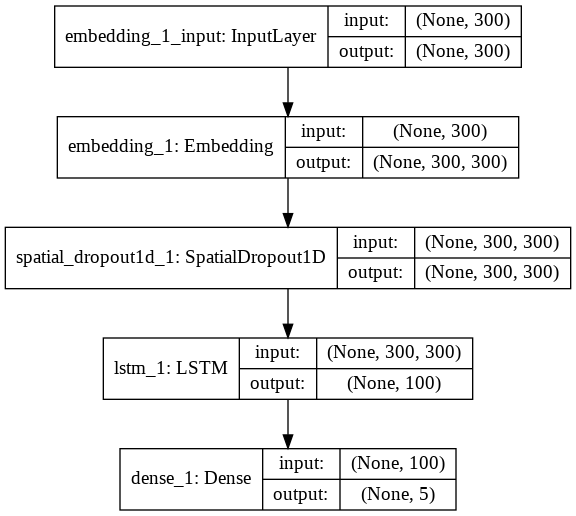

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Fitting and Testing of model

In [21]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 2079 samples, validate on 231 samples
Epoch 1/10
2079/2079 [==============================] - 31s 15ms/step - loss: 1.4146 - accuracy: 0.4281 - val_loss: 1.1082 - val_accuracy: 0.5628
Epoch 2/10
2079/2079 [==============================] - 30s 14ms/step - loss: 0.7222 - accuracy: 0.7557 - val_loss: 0.5329 - val_accuracy: 0.8701
Epoch 3/10
2079/2079 [==============================] - 30s 15ms/step - loss: 0.3202 - accuracy: 0.9274 - val_loss: 0.2325 - val_accuracy: 0.9481
Epoch 4/10
2079/2079 [==============================] - 30s 14ms/step - loss: 0.1386 - accuracy: 0.9721 - val_loss: 0.2283 - val_accuracy: 0.9221
Epoch 5/10
2079/2079 [==============================] - 30s 14ms/step - loss: 0.0953 - accuracy: 0.9740 - val_loss: 0.2021 - val_accuracy: 0.9221
Epoch 6/10
2079/2079 [==============================] - 30s 14ms/step - loss: 0.0619 - accuracy: 0.9856 - val_loss: 0.1910 - val_accuracy: 0.9481
Epoch 7/10
2079/2079 [==============================] - 30s 14ms/step - loss:

In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

770/770 [==============================] - 3s 4ms/step
Test set
  Loss: 0.340
  Accuracy: 0.906


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


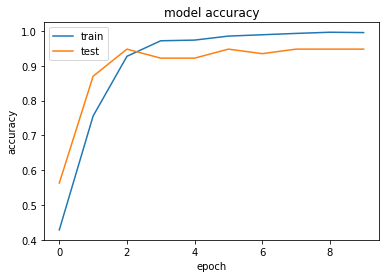

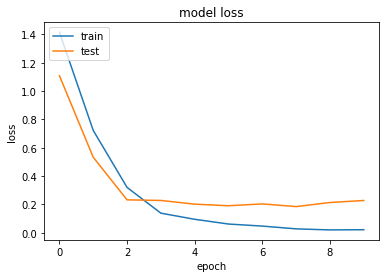

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# saving model as h5 file
model.save('Classification_LSTM_model.h5')

In [0]:
new_result = ['may coronavirus economic impact countries manufacture sectors affect covid crisis early evidence']
seq = tokenizer.texts_to_sequences(new_result)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
categories = ['Economy, Business & Politics', 'News', 'Research, Vaccine, Hospitals & Test kits', 'Jobs & Education', 'Donations & Food']
print(pred, categories[np.argmax(pred)])

### Another RNN model (but not used in deployment)

In [0]:
n_most_common_words = 1000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_tokens['tokens'].values)
sequences = tokenizer.texts_to_sequences(data_tokens['tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)
print(X.shape)

In [0]:
Y = pd.get_dummies(data_tokens['category']).values
print('Shape of label tensor:', Y.shape)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [0]:
epochs = 100
emb_dim = 128
batch_size = 256

In [0]:
print((X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

In [0]:
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
new_result = ['may coronavirus economic impact countries manufacture sectors affect covid crisis early evidence']
seq = tokenizer.texts_to_sequences(new_result)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
categories = ['Economy, Business & Politics', 'News', 'Research, Vaccine, Hospitals & Test kits', 'Jobs & Education', 'Donations & Food']
print(pred, categories[np.argmax(pred)])